In [1]:
from opt_lib import *
# Parameter definieren
dt = 0.001
L = 0.5
v_max = 32

test = data_class("TrafficDataset/sequence_data1-1_1.mat")
test.next_dataset() # Nächster Datensatz
test.next_dataset() # Nächster Datensatz
test.next_dataset() # Nächster Datensatz
test.LinInterplation(dt) # mit dt schrittweite, denn Datensatz interpolieren
print(test.test_interpolation(dt)) # durchschnittlicher Fehler der Interpolation abfragen
test.switch_iteration() # Die interpolierten werte als zu berücksichtigende Daten setzen

x_num = np.zeros_like(test.get_x())# Array definieren, in dem die numerisch bestimmten ort abgespeichert werden
J_array = np.zeros(test.get_t().shape[0] - 1) # Array definieren, in dem der Loss abgespeichert wird

for i in range(len(J_array)+1):
	x_soll, t_soll = test.getCurrentCoords() # Aktuelle ort, zeit punkte der autos ausgeben
	if i != 0: # Falls wir schon einen Schritt gegangen sind
		J_array[i-1] = J(x, dt, x_soll) # Loss berechnen
	else: # Falls der erste durchlauf
		x, t = x_soll, t_soll
	dist = d(x) # Distanzen zwischen den autos berechnen
	x, _ = single_step(x, v_max, L, dt, "lin") # x aktualisieren
	x_num[:,i] = x
	t += dt

test.getCurrentCoords() # Test, ob alle Daten abgegangen wurden

[6.33294764e-13 5.54756678e-13 2.16477404e-13]


(array([], dtype=float64), None)

In [ ]:
import pygame
pygame.init()
W, H = 900, 300
offset = 50
screen = pygame.display.set_mode((W + offset, H + offset))
clock = pygame.time.Clock()
scale = 10     # skaliert Meter → Pixel
running = True
time_lst = test.get_t()


WIDTH, HEIGHT = W, H
# Farben
WHITE = (255, 255, 255)
BLACK = (0, 0, 0)
GRAY = (200, 200, 200)
RED = (255, 0, 0)
BLUE = (0, 0, 255)

# Koordinatensystem-Einstellungen
ORIGIN_X = 100 # WIDTH // 2
ORIGIN_Y = 200 # HEIGHT // 2
GRID_SIZE = 50 # Abstand zwischen Gitterlinien

def draw_coordinate_system():
    """Zeichnet das statische Koordinatensystem"""
    # Gitterlinien
    for i in range(0, WIDTH, GRID_SIZE):
        # Vertikale Linien
        screen_x = ORIGIN_X + i
        pygame.draw.line(screen, GRAY, (screen_x, 0), (screen_x, HEIGHT), 1)
        
    # for i in range(0, HEIGHT, GRID_SIZE):
    #     # Horizontale Linien
    #     screen_y = ORIGIN_Y + i
    #     pygame.draw.line(screen, GRAY, (0, screen_y), (WIDTH, screen_y), 1)
    
    # Achsen (dicker)
    pygame.draw.line(screen, WHITE, (ORIGIN_X, 0), (ORIGIN_X, HEIGHT), 2)  # Y-Achse
    pygame.draw.line(screen, WHITE, (0, ORIGIN_Y), (WIDTH, ORIGIN_Y), 2)  # X-Achse
    
    # Beschriftungen
    font = pygame.font.Font(None, 20)
    
    # X-Achse Beschriftung
    for i in range(0, WIDTH, GRID_SIZE):
        if i != 0:
            screen_x = ORIGIN_X + i
            text = font.render(f"{i/scale_x: .3}", True, WHITE)
            screen.blit(text, (screen_x - 10, ORIGIN_Y + 5))
    
    # # Y-Achse Beschriftung (Y-Achse nach unten ist negativ)
    # for i in range(0, HEIGHT, GRID_SIZE):
    #     if i != 0:
    #         screen_y = ORIGIN_Y + i
    #         text = font.render(str(-i), True, WHITE)
    #         screen.blit(text, (ORIGIN_X + 5, screen_y - 10))
    
    # Ursprung
    text = font.render("0", True, WHITE)
    screen.blit(text, (ORIGIN_X + 5, ORIGIN_Y + 5))
def start_pos(x):
	pos = np.zeros_like(x)
	for i in range(pos.shape[0]):
		pos[i] = x[i] - np.min(x)
	return pos

xmins_n = np.min(x_num, 1)
xmins_data = np.min(test.get_x(), 1)
start_n = start_pos(xmins_n)
start_data = start_pos(xmins_data)

scale_x = (W-ORIGIN_X)/np.max((test.get_x()) - np.min(test.get_x())) # 
for x_n, x_data, time in zip(x_num.T, test.get_x().T, time_lst-np.min(time_lst)):
	clock.tick(60) # 60 FPS
	for event in pygame.event.get():
		if event.type == pygame.QUIT:
			running = False             # Stop when closed
	if not running:
		break			# Stop when closed
	
	screen.fill((30, 30, 30))
	draw_coordinate_system()
	for i, xn, xd in zip(range(len(x_n)), x_n, x_data): 
		pygame.draw.circle(screen, RED, ((xn - xmins_n[i]) * scale_x + start_n[i]* scale_x + ORIGIN_X, 70), 5) #cars
		pygame.draw.circle(screen, BLUE, ((xd - xmins_data[i]) * scale_x + start_data[i]* scale_x + ORIGIN_X, 150), 5) #cars

	pygame.display.flip() # display and render 
pygame.quit()

c:\Users\tlock\miniconda3\envs\Opt1\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


pygame 2.6.1 (SDL 2.28.4, Python 3.12.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
# mittelpunktsregel fpr das integral

def single_step_P(x, v_max, L, dt, model):
    N = len(x) # Number of initial values == number of vehicles in traffic
    dx = np.zeros(N) # momente initialisieren
    # Leader
    # dx[-1] = v_max
    dist = d(x)/L
    # for i in range(N):
    #         dx[i] = f(dist[i], v_max, model)
    dx = P(dist, v_max, model)
    return x + dt * dx, dx

def P():
    return
    
def adjungierte(xn, vmax, P):
    return 

In [ ]:
from opt_lib import *
# Parameter definieren
dt = 0.001
L = 0.5
v_max = 32

test = data_class("TrafficDataset/sequence_data1-1_1.mat")
test.next_dataset() # Nächster Datensatz
test.next_dataset() # Nächster Datensatz
test.next_dataset() # Nächster Datensatz
test.LinInterplation(dt) # mit dt schrittweite, denn Datensatz interpolieren
print(test.test_interpolation(dt)) # durchschnittlicher Fehler der Interpolation abfragen
test.switch_iteration() # Die interpolierten werte als zu berücksichtigende Daten setzen

x_num = np.zeros_like(test.get_x())# Array definieren, in dem die numerisch bestimmten ort abgespeichert werden
J_array = np.zeros(test.get_t().shape[0] - 1) # Array definieren, in dem der Loss abgespeichert wird

for i in range(len(J_array)+1):
	x_soll, t_soll = test.getCurrentCoords() # Aktuelle ort, zeit punkte der autos ausgeben
	if i != 0: # Falls wir schon einen Schritt gegangen sind
		J_array[i-1] = J(x, dt, x_soll) # Loss berechnen
	else: # Falls der erste durchlauf
		x, t = x_soll, t_soll
	x, _ = single_step(x, v_max, L, dt, "lin") # x aktualisieren
	x_num[:,i] = x
	t += dt

test.getCurrentCoords() # Test, ob alle Daten abgegangen wurden

In [4]:
def set_numx(self, dt, L, v_max, n_dataset = self.__counter, model = "log"):
	self.next_dataset(n_dataset) # auf den gewollten Datensatz wechseln
	self.LinInterplation(dt) # durchschnittlicher Fehler der Interpolation abfragen
	self.switch_iteration() # Die interpolierten werte als zu berücksichtigende Daten setzen
	self.__numx = np.zeros_like(self.get_x()) # Array definieren, in dem die numerisch bestimmten orte gespeichert werden
	self.__J = np.zeros(self.get_t().shape[0] - 1)
	for i in range(len(self.__J)+1):
		x_soll, t_soll = self.getCurrentCoords() # Aktuelle ort, zeit punkte der autos ausgeben
		if i != 0: # Falls wir schon einen Schritt gegangen sind
			self.__J[i-1] = self.J(x, dt, x_soll) # Loss berechnen
		else: # Falls der erste durchlauf
			x, t = x_soll, t_soll # Startpositionen initialisieren
		x, _ = single_step(x, v_max, L, dt, model) # x aktualisieren
		x_num[:,i] = x
		t += dt


	self.__gesx.append(self.__x)
	self.__gesnumx.append(self.__numx)
	return	self.__numx


NameError: name 'self' is not defined

In [ ]:
from mat4py import loadmat
import numpy as np
class data_class():
	__data = []
	__len = 0
	__x = np.ndarray
	__t = np.ndarray
	__counter = 0
	__unterCounter = 0
	__xIt = np.ndarray
	__tIt = np.ndarray
	__ItError = np.ndarray
	__numx = np.ndarray	
	__J = np.ndarray
	__gesx = []
	__gesnumx = []
	__d = np.ndarray

	def get_d(self):
		return self.__d
	def get_numx(self):
		return self.__numx
	def get_J(self):
		return self.__J
	def get_gesx(self):
		return self.__gesx
	def get_gesnumx(self):
		return self.__gesnumx
	def get_len(self):
		return self.__len
	def get_x(self):
		return self.__x
	def get_t(self):
		return self.__t
	def get_tIt(self):
		return self.__tIt
	def get_xIt(self):
		return self.__xIt
	def get_ItError(self):
		return self.__ItError
	def set_x(self, x):
		self.__x = x
		return 
	def set_t(self, x):
		self.__t = x
		return
	def set_counter(self, x):
		self.__counter = x
		return
	def __init__(self, path):
		self.__data = loadmat(path)["sequences"][:]
		self.__len = len(self.__data)
		self.__counter = 0
		self.setXYTFromData(self.__counter)
		return
	def setXYTFromData(self, x):
		self.__x = np.array(self.__data[x][0].get("Xarr"))
		self.__t = np.array(self.__data[x][0].get("Tarr"))
		return 
	def next_dataset(self, dataset_num = None):
		if dataset_num == None:
			if self.__counter < self.__len - 1:
				self.__counter += 1
				self.setXYTFromData(self.__counter)
				return
			else:
				self.__counter += 1
				print(f"Error: Index {self.__counter} is out of range of the dataset with length {self.__len} !!!")
				return
		else:
			if dataset_num < self.__len - 1:
				self.__counter = dataset_num
				self.setXYTFromData(self.__counter)
				return
			else:
				self.__counter = dataset_num
				print(f"Error: Index {self.__counter} is out of range of the dataset with length {self.__len} !!!")
				return

	def getCurrentCoords(self, i=None):
		if i == None:
			i = self.__unterCounter
		maxZeilen = self.__x.shape[0]
		maxSpalten = self.__x.shape[1]
		xVals = np.array([self.__x[j, i] for j in range(maxZeilen) if i < maxSpalten])
		tVal = self.__t[i] if i < maxSpalten else None

		if i == self.__unterCounter:
			self.__unterCounter += 1
		return xVals, tVal

	def J (self, x, dt, x_data):
		result = 0
		for i in range(len(x)):
			result += dt * np.abs(x[i] - x_data[i])**2
		return result
	
	def set_numx(self, dt, L, v_max, n_dataset = __counter, model = "log"):
		self.next_dataset(n_dataset) # auf den gewollten Datensatz wechseln
		self.LinInterplation(dt) # durchschnittlicher Fehler der Interpolation abfragen
		self.switch_iteration() # Die interpolierten werte als zu berücksichtigende Daten setzen
		self.__numx = np.zeros_like(self.get_x()) # Array definieren, in dem die numerisch bestimmten orte gespeichert werden
		self.__J = np.zeros(self.get_t().shape[0] - 1)
		for i in range(len(self.__J)+1):
			x_soll, t_soll = self.getCurrentCoords() # Aktuelle ort, zeit punkte der autos ausgeben
			if i != 0: # Falls wir schon einen Schritt gegangen sind
				self.__J[i-1] = self.J(x, dt, x_soll) # Loss berechnen
			else: # Falls der erste durchlauf
				x, t = x_soll, t_soll # Startpositionen initialisieren
			x, _ = self.single_step(x, v_max, L, dt, model) # x aktualisieren
			self.__numx[:,i] = x
			t += dt

		self.__gesx.append(self.__x)
		self.__gesnumx.append(self.__numx)
		return	self.__numx

	def f (self, d, v_max, model = "log"):
		if model == "log":
			return np.min([v_max * np.log(d), np.ones_like(d) * v_max], 0) # Limit v_max, wie im linearen modell
		else: # lin
			return v_max * (1 - 1/d)
	
	def single_step(self, x, v_max, L, dt, model):
		N = len(x) # Number of initial values == number of vehicles in traffic
		dx = np.zeros(N) # momente initialisieren
		# Leader
		# dx[-1] = v_max
		dist = self.d(x)/L
		# for i in range(N):
		#         dx[i] = f(dist[i], v_max, model)
		dx = self.f(dist, v_max, model)
		return x + dt * dx, dx


	def switch_iteration(self):
		copy_x = self.__x.copy()
		copy_t = self.__t.copy()
		self.__x = self.__xIt 
		self.__t = self.__tIt 
		self.__xIt = copy_x
		self.__tIt = copy_t

	def test_correl(self, limit = 0.03):	
		corell = np.zeros(self.__x.shape[0])
		for i, auto in enumerate(self.__x):
			corell[i] = 1 - np.corrcoef(self.__t, auto)[0, 1]
		if np.sum(corell >= limit) >= 1:
			print(f"ACHTUNG mindestenz einmal eine größere Abweichung als {limit}")
		self.__ItError = corell
		return corell


	def test_interpolation(self, dt):
		rel_fehler = np.zeros(self.__x.shape[0])
		for i, auto in enumerate(self.__x):
			for x, t in zip(auto, self.__t):
				index = np.where((self.__tIt >= (t - dt/2)) & (self.__tIt <= (t + dt/2)))[0]
				if len(index) != 0:
					abs_fehler = np.abs(x-self.__xIt[i, index])
					rel_fehler[i] = rel_fehler[i] + abs_fehler/np.abs(x)
		avg_fehler = rel_fehler/len(self.__t)
		if np.sum(avg_fehler >= 0.05) > 1:
			print("ACHTUNG mindestenz einmal eine größere Abweichung als 5%")
		self.__ItError = avg_fehler
		return avg_fehler

	def LinApprox(self, dt=0.001):
		if np.sum(self.test_correl() >= 0.03) >= 1:
			print(f"ACHTUNG mindestenz einmal eine größere Abweichung als {0.03}")
		
		ort = self.__x
		zeit = self.__t
		zeit_int = np.arange(zeit[0], zeit[-1], dt)
		ort_int = np.zeros((ort.shape[0], len(zeit_int)))
		for i, auto in enumerate(ort):
			steigung = (np.max(auto)-np.min(auto))/(np.max(zeit)-np.min(zeit))
			ort_int[i,:] = steigung * np.arange(0, np.max(zeit)-np.min(zeit), dt) + np.min(auto)

		self.__xIt = ort_int
		self.__tIt = zeit_int
		# self.test_interpolation(dt)
		return ort_int, zeit_int


	def LinInterplation(self, dt=0.001):
		if np.sum(self.test_correl() >= 0.03) >= 1:
			print(f"ACHTUNG mindestenz einmal eine größere Abweichung als {0.03}")
		
		ort = self.__x
		zeit = self.__t
		zeit_int = np.arange(zeit[0], zeit[-1], dt)
		ort_int = np.zeros((ort.shape[0],*zeit_int.shape))
		for i, auto in enumerate(ort):
			ort_int[i, :] = np.interp(zeit_int, zeit, auto)
		self.__xIt = ort_int
		self.__tIt = zeit_int
		# self.test_interpolation(dt)
		return ort_int, zeit_int
	
	def d(self, x:np.ndarray): # Abstandsfunktion
		d = np.ones_like(x) * np.inf # anfangs distanz auf sehr groß setzen
		order_mask = np.argsort(x) # nach i-ter achse sortieren, hier x achse -> 0
		x_ordered = x[order_mask]
		for i in range(len(x_ordered)-1):
			dist = np.linalg.norm(x_ordered[i] - x_ordered[i+1]) # Da die werte geordnet sind, muss nur die Distanz zum nächsten auto berücksichtigt werden
			d[i] = dist if d[i] > dist else d[i]
				
		reordered_d = d[np.argsort(order_mask)]
		return reordered_d

In [20]:
# Parameter definieren
dt = 0.001
L = 0.5
v_max = 32

test = data_class("TrafficDataset/sequence_data1-1_1.mat")
test.set_numx(dt, L, v_max, model="log")

array([[47.42331046, 47.45531046, 47.48731046, ..., 60.12731046,
        60.15931046, 60.19131046],
       [51.42204619, 51.45404619, 51.48604619, ..., 64.12604619,
        64.15804619, 64.19004619],
       [71.56257024, 71.59457024, 71.62657024, ..., 84.26657024,
        84.29857024, 84.33057024]], shape=(3, 400))

In [21]:
import pygame
pygame.init()
W, H = 900, 300
offset = 50
screen = pygame.display.set_mode((W + offset, H + offset))
clock = pygame.time.Clock()
scale = 10     # skaliert Meter → Pixel
running = True
time_lst = test.get_t()


WIDTH, HEIGHT = W, H
# Farben
WHITE = (255, 255, 255)
BLACK = (0, 0, 0)
GRAY = (200, 200, 200)
RED = (255, 0, 0)
BLUE = (0, 0, 255)

# Koordinatensystem-Einstellungen
ORIGIN_X = 100 # WIDTH // 2
ORIGIN_Y = 200 # HEIGHT // 2
GRID_SIZE = 50 # Abstand zwischen Gitterlinien

def draw_coordinate_system():
    """Zeichnet das statische Koordinatensystem"""
    # Gitterlinien
    for i in range(0, WIDTH, GRID_SIZE):
        # Vertikale Linien
        screen_x = ORIGIN_X + i
        pygame.draw.line(screen, GRAY, (screen_x, 0), (screen_x, HEIGHT), 1)
        
    # for i in range(0, HEIGHT, GRID_SIZE):
    #     # Horizontale Linien
    #     screen_y = ORIGIN_Y + i
    #     pygame.draw.line(screen, GRAY, (0, screen_y), (WIDTH, screen_y), 1)
    
    # Achsen (dicker)
    pygame.draw.line(screen, WHITE, (ORIGIN_X, 0), (ORIGIN_X, HEIGHT), 2)  # Y-Achse
    pygame.draw.line(screen, WHITE, (0, ORIGIN_Y), (WIDTH, ORIGIN_Y), 2)  # X-Achse
    
    # Beschriftungen
    font = pygame.font.Font(None, 20)
    
    # X-Achse Beschriftung
    for i in range(0, WIDTH, GRID_SIZE):
        if i != 0:
            screen_x = ORIGIN_X + i
            text = font.render(f"{i/scale_x: .3}", True, WHITE)
            screen.blit(text, (screen_x - 10, ORIGIN_Y + 5))
    
    # # Y-Achse Beschriftung (Y-Achse nach unten ist negativ)
    # for i in range(0, HEIGHT, GRID_SIZE):
    #     if i != 0:
    #         screen_y = ORIGIN_Y + i
    #         text = font.render(str(-i), True, WHITE)
    #         screen.blit(text, (ORIGIN_X + 5, screen_y - 10))
    
    # Ursprung
    text = font.render("0", True, WHITE)
    screen.blit(text, (ORIGIN_X + 5, ORIGIN_Y + 5))
def start_pos(x):
	pos = np.zeros_like(x)
	for i in range(pos.shape[0]):
		pos[i] = x[i] - np.min(x)
	return pos

xmins_n = np.min(test.get_numx(), 1)
xmins_data = np.min(test.get_x(), 1)
start_n = start_pos(xmins_n)
start_data = start_pos(xmins_data)

scale_x = (W-ORIGIN_X)/np.max((test.get_x()) - np.min(test.get_x())) # 
for x_n, x_data, time in zip(test.get_numx().T, test.get_x().T, time_lst-np.min(time_lst)):
	clock.tick(60) # 60 FPS
	for event in pygame.event.get():
		if event.type == pygame.QUIT:
			running = False             # Stop when closed
	if not running:
		break			# Stop when closed
	
	screen.fill((30, 30, 30))
	draw_coordinate_system()
	for i, xn, xd in zip(range(len(x_n)), x_n, x_data): 
		pygame.draw.circle(screen, RED, ((xn - xmins_n[i]) * scale_x + start_n[i]* scale_x + ORIGIN_X, 70), 5) #cars
		pygame.draw.circle(screen, BLUE, ((xd - xmins_data[i]) * scale_x + start_data[i]* scale_x + ORIGIN_X, 150), 5) #cars

	pygame.display.flip() # display and render 
pygame.quit()

In [25]:
import numpy as np
np.flip(np.arange(10, 0, -0.1))

array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
        1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,
        2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,  3.3,
        3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,  4.4,
        4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,  5.5,
        5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,  6.6,
        6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,  7.7,
        7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,  8.8,
        8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,  9.9,
       10. ])

In [75]:
def p1(dt, data:data_class, v_max, d):
	p1 = np.zeros_like(data.get_x()[0,:]) # anpassen
	t_arr = np.flip(data.get_t())
	for i, j in enumerate(t_arr):
		if i == 0:
			p = 0
		else:
			p = p + dt * 2*(data.get_numx()[0,-i]-data.get_x()[0,-i]) - dt * p * (v_max/d[-i])
		p1[-i] = p
	return p1

def p2_N_1(dt, data:data_class, pi_1, d, n, v_max): # n tes auto
	pi = np.zeros_like(data.get_x()[1:-1,:])[0] # anpassen
	t_arr = np.flip(data.get_t())
	for i, j in enumerate(t_arr):
		if i == 0:
			p = 0
		else:
			p = p + dt * 2*(data.get_numx()[n,-i]-data.get_x()[n,-i]) - dt * p * (v_max/d[-i]) + dt * pi_1[-i] * v_max/d[-i]
		pi[-i] = p
	return pi

def pN(dt, data:data_class, pi_1, d, v_max): # n tes auto
	pi = np.zeros_like(data.get_x()[1:-1,:])[0] # anpassen
	t_arr = np.flip(data.get_t())
	for i, j in enumerate(t_arr):
		if i == 0:
			p = 0
		else:
			p = p + dt * 2*(data.get_numx()[-1,-i]-data.get_x()[-1,-i]) + dt * pi_1[-i] * v_max/d[-i]
		pi[-i] = p
	return pi


def pGes(dt, data:data_class, v_max):
	darr = np.array([data.d(i) for i in data.get_x().T])
	pges = np.zeros_like(data.get_x())
	pges[0,:] = p1(dt, data, v_max, darr[:,0])
	for n in range(1, pges.shape[0]-1):
		pges[n,:] = p2_N_1(dt, data, pges[n-1,:], darr[:,n], n, v_max)
	pges[n+1,:] = pN(dt, data, pges[n,:], darr[:,-1], v_max)
	return pges

In [ ]:
darr = np.array([test.d(i) for i in test.get_x().T])
darr[:,0]

array([ 3.99873573, 20.14052405,         inf])

In [ ]:
pGes(dt, test, v_max)

array([[ 0.00000000e+00,  3.82584808e-03,  3.79257350e-03, ...,
        -4.45601574e-04, -3.53816085e-04, -2.21444405e-04],
       [ 0.00000000e+00,  1.14583461e+00,  1.14756466e+00, ...,
         2.28131995e-02,  1.52354919e-02,  7.63112426e-03],
       [ 0.00000000e+00,  6.82125277e-01,  6.82054533e-01, ...,
         1.17786427e-02,  7.86512213e-03,  3.93890791e-03]],
      shape=(3, 400))

In [ ]:
def integral(arg, dt):
    res = np.array([arg[i] * dt for i in range(arg.shape[0])])
    return np.sum(res)

def gradient(P_ges, d, v_max, L, dt):
    sk0 = integral(P_ges[-1] + np.sum(np.array([P_ges[i] * np.log(d[i]/L) for i in range(P_ges.shape[0]-1)]), axis=0), dt)
    sk1 = integral(np.sum(np.array([P_ges[i] * v_max/L for i in range(P_ges.shape[0]-1)]), axis=0), dt)
    return (sk0, sk1)

Pges = pGes(dt, test, v_max)
d = np.array([test.d(i) for i in test.get_x().T]).T


(np.float64(1.5139223602321672), np.float64(22.627023373735156))

In [ ]:
N = 5


sk = gradient(Pges, d, v_max, L, dt)
sigma = 0.01 # Amijo Bed.
for k in range(N):
    direction = sk
    # (update stepsize) bei uns fix
    v_max = v_max + sigma * sk[0]
    L = L + sigma * sk[1] 

In [12]:
from opt_lib import *
# Parameter definieren
dt = 0.001
L = 1
v_max = 35

test = data_class("TrafficDataset/sequence_data1-1_1.mat")
test.set_numx(dt, L, v_max, model="log", n_dataset=2)
Pges = pGes(dt, test, v_max)
d = np.array([test.d(i) for i in test.get_x().T]).T
sk = gradient(Pges, d, v_max, L, dt)
sk

(np.float64(26.734219768261777), np.float64(233.92808031000743))

In [32]:
N = 100
gradients = np.zeros((2, N))
vmax_arr = np.zeros(N)
L_arr = np.zeros(N)
sigma = 0.01 # Amijo Bed.

test = data_class("TrafficDataset/sequence_data1-1_1.mat")
for k in range(N):
	test.set_numx(dt, L, v_max, model="log", n_dataset=2)
	Pges = pGes(dt, test, v_max)
	d = np.array([test.d(i) for i in test.get_x().T]).T
	sk = gradient(Pges, d, v_max, L, dt)
	# (update stepsize) bei uns fix
	v_max = v_max + sigma * sk[0]
	L = L + sigma * sk[1] 
	gradients[:, k] = sk
	vmax_arr[k] = v_max
	L_arr[k] = L

ValueError: could not broadcast input array from shape (0,) into shape (3,)

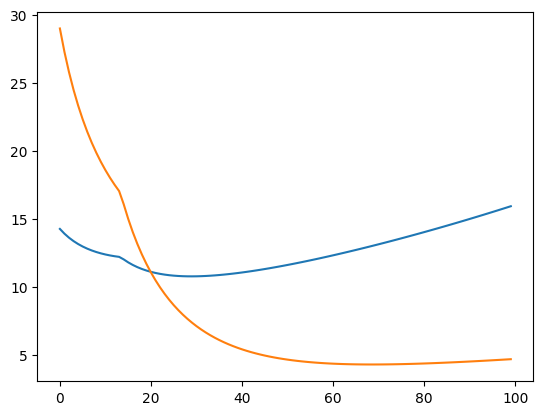

In [29]:
import matplotlib.pyplot as plt
plt.plot(range(N), gradients[0,:])
plt.plot(range(N), gradients[1,:])

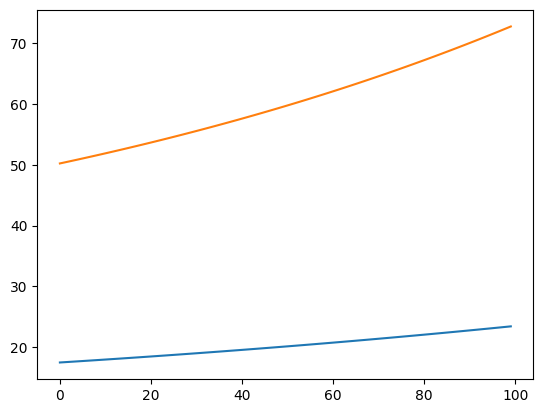

In [31]:
plt.plot(range(N), L_arr)
plt.plot(range(N), vmax_arr)

# Alles zusammen!!!